In [1]:
import re
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


amdgpu.ids: No such file or directory


In [3]:
def count_parameters(model):
    for name, module in model.named_modules():
        params = sum(p.numel() for p in module.parameters())
        print(f"{name}: {params} parameters")

# Dataset and Dataloader

To investigate: Normalization or other transforms

In [4]:
class NormalizeECG:
    def __call__(self, tensor):
        # Z-score normalization per lead
        means = tensor.mean(dim=1, keepdim=True)
        stds = tensor.std(dim=1, keepdim=True)
        return (tensor - means) / (stds + 1e-8)

In [5]:
class ECGDataset(Dataset):
    def __init__(self, path="data/ecg", diagnoses='data/diagnoses.csv', transform=None):
        # Store file paths with cleaned IDs
        self.file_info = []  # List of tuples (cleaned_id, file_path)
        
        # Extract numeric IDs from filenames
        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith('.csv'):
                    # Extract numeric part from filename (e.g., "abc00001.csv" -> "00001")
                    cleaned_id = re.sub(r'\D', '', file)
                    self.file_info.append((
                        cleaned_id,
                        os.path.join(root, file)
                    ))

        # Load and prepare labels
        self.labels_df = pd.read_csv(diagnoses)
        # Clean IDs in both DataFrame and our file list
        self.labels_df['ID'] = self.labels_df['ID'].astype(str).str.replace(r'\D', '', regex=True)
        self.labels_df.set_index('ID', inplace=True)

        # Filter out files without corresponding labels
        valid_ids = set(self.labels_df.index)
        self.file_info = [(i, p) for i, p in self.file_info if i in valid_ids]

        self.transform = transform
        self.cache = {}

    def __len__(self):
        return len(self.file_info)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]

        cleaned_id, file_path = self.file_info[idx]
        
        try:
            # Load ECG data
            df = pd.read_csv(file_path)
            ecg_data = df.drop(columns=['time']).values
            tensor = torch.tensor(ecg_data, dtype=torch.float32).T  # (leads, timesteps)
            
            if self.transform:
                tensor = self.transform(tensor)
                
            # Get corresponding label
            label_values = self.labels_df.loc[cleaned_id].values  # Get all label columns
            label = torch.tensor(label_values, dtype=torch.float32)  # Use float for multi-label

            return tensor, label
            
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            # Return zero tensor and -1 label placeholder
            return torch.zeros((12, 5000)), torch.tensor(-1, dtype=torch.float32)


In [6]:
dataset = ECGDataset()
data, label = dataset.__getitem__(0)
print(data.shape)
print(label.shape)

torch.Size([12, 5000])
torch.Size([94])


# Basic Transformer

In [7]:
class ECGTransformer(nn.Module):
    def __init__(self, d_model, num_classes=63, nhead=8, num_encoder_layers=2, dim_feedforward=2048):
        super().__init__()
        
        # Define encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=dim_feedforward, batch_first=True)

        # Encoder stack
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)
        
    def forward(self, x):
        encoded = self.transformer(x)
        # encoded shape: (batch_size, seq_len, d_model)
        # Pick out only the last in the sequence for classification
        encoded = encoded[:, -1, :]
        result = self.classifier(encoded)
        return result

In [8]:
model = ECGTransformer(d_model=12, nhead=4, num_classes=63, num_encoder_layers=6, dim_feedforward=512)
print(model)
count_parameters(model)

ECGTransformer(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=12, out_features=63, bias=True)
)
: 81723 parameters
transformer: 80904 parameters
transformer.layers: 80904 parameters
transformer.layers.0: 13484 parameters
transformer.layers.0.self_attn: 624 parameters
transformer.layers.0.self_attn.out_proj:

# An embedding model 
that uses convolution

Convolution turning 12 channels to 128, repeated to transfer forward 200ms.


In [9]:
class ECGEmbeddings(nn.Module):
    def __init__(self, d_input, d_model):
        super().__init__()
        # Keep original layers
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(d_model if i>0 else d_input, d_model, 50, stride=1, padding='same')
            for i in range(8)
        ])
        self.activation = nn.ReLU(inplace=False)  # Important for checkpointing

    def forward(self, x):
        # Split into gradient checkpoint blocks
        def run_block(x, start, end):
            for i in range(start, end+1):
                x = self.conv_layers[i](x)
                x = self.activation(x)
            return x

        if not x.requires_grad:
            x = x.detach().requires_grad_(True)
        
        # Checkpoint groups of layers
        x = torch.utils.checkpoint.checkpoint(run_block, x, 0, 3, use_reentrant=False)  # Layers 0-3
        x = torch.utils.checkpoint.checkpoint(run_block, x, 4, 7, use_reentrant=False)  # Layers 4-7
        return x

In [10]:
embedding_model = ECGEmbeddings(d_input = 12, d_model=512)
print(embedding_model)
count_parameters(embedding_model)

ECGEmbeddings(
  (conv_layers): ModuleList(
    (0): Conv1d(12, 512, kernel_size=(50,), stride=(1,), padding=same)
    (1-7): 7 x Conv1d(512, 512, kernel_size=(50,), stride=(1,), padding=same)
  )
  (activation): ReLU()
)
: 92061696 parameters
conv_layers: 92061696 parameters
conv_layers.0: 307712 parameters
conv_layers.1: 13107712 parameters
conv_layers.2: 13107712 parameters
conv_layers.3: 13107712 parameters
conv_layers.4: 13107712 parameters
conv_layers.5: 13107712 parameters
conv_layers.6: 13107712 parameters
conv_layers.7: 13107712 parameters
activation: 0 parameters


# A possible better patch-based embedding model
Attempt to extract each heartbeat as a "word", then create an embedding of that beat.

Creating patches like the ViT architecture

In [11]:
# From the raw data, split into patches
class Splitter(nn.Module):
    def __init__(self, d_model, patch_size=50): # Try 50-100 ballpark
        super().__init__()
        self.patch_size = patch_size
        # It's conv function but really just breaking into patches
        self.projection = nn.Conv1d(12, d_model, patch_size, stride=patch_size) 

    def forward(self, x):
        # Reshape input to split into patches
        x = self.projection(x)
        return x.permute(0, 2, 1)

In [18]:
# Takes in the patches and adds the positional embeddings
class PatchPositionalEncoding(nn.Module):
    def __init__(self, num_patches, d_model):
        super().__init__()
        self.num_patches = num_patches
        self.d_model = d_model
        self.pos_embedding = self.create_position_encoding().to(device)

    def create_position_encoding(self):
        pos = np.arange(self.num_patches).reshape(-1, 1)
        dim = np.arange(self.d_model).reshape(1, -1)

        angle_rates = 1/np.power(10000, (2*(dim//2))/np.float32(self.d_model))
        position_encoding = pos*angle_rates  # Positional information
        # Apply sine to even indices and cosine to odd indices
        position_encoding[:, 0::2] = np.sin(position_encoding[:, 0::2])
        position_encoding[:, 1::2] = np.cos(position_encoding[:, 1::2])
        return torch.tensor(position_encoding, dtype=torch.float32)

    def forward(self, x):
        return x + self.pos_embedding

# Combining together embedding with transformer

In [13]:
class ECGCombined(nn.Module):
    def __init__(self, d_input, d_model, num_classes=63, nhead=8, num_encoder_layers=2, dim_feedforward=2048):
        super().__init__()
        
        self.embedding_model = ECGEmbeddings(d_input, d_model)
        self.transformer = ECGTransformer(d_model, num_classes, nhead, num_encoder_layers, dim_feedforward)

    def forward(self, x):
        x = self.embedding_model(x)
        x = x.permute(0, 2, 1)       # Reshape to (batch_size, seq_len, d_model)
        x = self.transformer(x)
        return x

In [14]:
class ECGPatchCombined(nn.Module):
    def __init__(self, d_input, d_model, num_classes=63, nhead=8, num_encoder_layers=2, dim_feedforward=2048, num_patches=100):
        super().__init__()
        self.splitter = Splitter(d_model, patch_size=50)
        self.patch_position = PatchPositionalEncoding(num_patches=num_patches, d_model=d_model)
        self.transformer = ECGTransformer(d_model, num_classes, nhead, num_encoder_layers, dim_feedforward)

    def forward(self, x):
        x = self.splitter(x)
        x = self.patch_position(x)   # Already (batch_size, seq_len, d_model)
        x = self.transformer(x)
        return x

# Trainer class

In [15]:
class Trainer:
    def __init__(self, model, device, accum_steps=4, checkpoint_interval=100,
                 resume_checkpoint=None):
        self.model = model
        self.device = device
        self.accum_steps = accum_steps
        self.checkpoint_interval = checkpoint_interval
        
        # Initialize essential components first
        self.scaler = torch.cuda.amp.GradScaler()
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=1e-4,
            betas=(0.9, 0.99),    # Increased second moment decay
            weight_decay=1e-3,    # Stronger regularization
            amsgrad=True
        )

        # Add scheduler
        total_batches = len(train_dataloader) // accum_steps * 1
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=total_batches//4,  # Number of batches between restarts
            eta_min=1e-6  # Minimum learning rate
        )

        self.loss_history = []
        self.acc_history = []
        self.batch_count = 0
        self.start_epoch = 0
        self.start_batch = 0

        # Override with checkpoint if provided
        if resume_checkpoint:
            self._load_checkpoint(resume_checkpoint)

    def _load_checkpoint(self, checkpoint_path):
        """Load training state from checkpoint"""
        checkpoint = torch.load(checkpoint_path)
        
        # Essential parameters
        self.model.load_state_dict(checkpoint['model_state'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state'])
        self.scaler.load_state_dict(checkpoint['scaler_state'])
        
        # Training progress
        self.loss_history = checkpoint['loss_history']
        self.acc_history = checkpoint['acc_history']
        self.batch_count = checkpoint.get('batch_count', 0)
        self.start_epoch = checkpoint['epoch']  # Resume from same epoch
        self.start_batch = checkpoint.get('batch', 0) + 1  # Next batch
        
        # Configurations (optional but recommended)
        self.checkpoint_interval = checkpoint.get('checkpoint_interval', 
                                                 self.checkpoint_interval)
        
        print(f"Resuming from epoch {self.start_epoch} batch {self.start_batch}")

    def loss(self, output, target):
        return F.binary_cross_entropy_with_logits(output, target.float())

    def train(self, train_dataloader, test_dataloader, num_epochs, save_path="training_progress"):
        os.makedirs(save_path, exist_ok=True)
        self.model.train()
        
        # Start from the last checkpoint epoch
        for epoch in range(self.start_epoch, num_epochs):
            # Skip batches we've already processed in this epoch
            for batch_idx, (inputs, labels) in enumerate(train_dataloader):
                if batch_idx < self.start_batch:
                    continue
                # Forward pass
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = self.model(inputs)
                    loss = self.loss(outputs, labels) / self.accum_steps

                # Backward pass
                self.scaler.scale(loss).backward()
                
                # Gradient accumulation
                if (batch_idx + 1) % self.accum_steps == 0:
                    self._update_parameters()
                
                # Logging and checkpointing
                current_loss = loss.item() * self.accum_steps
                self.loss_history.append(current_loss)
                self.batch_count += 1

                # Print every batch
                print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx+1}/{len(train_dataloader)} | "
                    f"Loss: {current_loss:.4f} | LR: {self.optimizer.param_groups[0]['lr']:.3e}")

                # Save checkpoint
                if self.batch_count % self.checkpoint_interval == 0:
                    acc = self.evaluate(test_dataloader)
                    self.acc_history.append([self.batch_count, acc])
                    self._save_checkpoint(save_path, epoch, batch_idx)
                
                del inputs, labels, outputs, loss

    def evaluate(self, dataloader):
        self.model.eval()
        total_mismatches = 0.0
        total_labels = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                
                # Get binary predictions (0 or 1) using threshold
                predicted = (torch.sigmoid(outputs) >= 0.5).float()
                
                # Calculate mismatches
                mismatches = (predicted != labels).float().sum().item()
                total_mismatches += mismatches
                total_labels += labels.numel()  # Total labels = batch_size * num_classes

        hamming_loss = total_mismatches / total_labels
        print(f'Hamming Loss: {hamming_loss:.4f}')
        return hamming_loss


    def _update_parameters(self):
        """Update model parameters with gradient clipping"""
        self.scaler.unscale_(self.optimizer)
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5.0)
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.optimizer.zero_grad()
        self.scheduler.step()

    def _save_checkpoint(self, path, epoch, batch_idx):
        """Save model and training state"""
        checkpoint = {
            'epoch': epoch,
            'batch': batch_idx,
            'batch_count': self.batch_count,
            'checkpoint_interval': self.checkpoint_interval,
            'model_state': self.model.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
            'loss_history': self.loss_history,
            'acc_history': self.acc_history,
            'scaler_state': self.scaler.state_dict(),
            'scheduler_state': self.scheduler.state_dict()
        }
        
        torch.save(checkpoint, f"{path}/checkpoint_ep{epoch}_b{batch_idx}.pt")
        print(f"\nCheckpoint saved at epoch {epoch+1} batch {batch_idx+1}")
        
        # Save loss history separately for easy plotting
        np.save(f"{path}/loss_history.npy", np.array(self.loss_history))
        np.save(f"{path}/acc_history.npy", np.array(self.acc_history))


# Let's Go Training

In [16]:
ecg_dataset = ECGDataset(transform=None)
train_dataset, test_dataset, val_dataset = random_split(
                                            ecg_dataset, [len(ecg_dataset) - 1000, 500, 500], 
                                            torch.Generator().manual_seed(42))

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Start from 0:

In [ ]:
model = ECGCombined(d_input=12, d_model=128, num_classes=94, nhead=4, num_encoder_layers=2, dim_feedforward=256).to(device)
trainer = Trainer(model, device, accum_steps=4)
trainer.train(train_dataloader, test_dataloader, num_epochs=1)

In [21]:
model = ECGPatchCombined(d_input=12, d_model=128, num_classes=94, nhead=4, num_encoder_layers=2, dim_feedforward=256, num_patches=100).to(device)
trainer = Trainer(model, device, accum_steps=4)
trainer.train(train_dataloader, test_dataloader, num_epochs=1)

/tmp/ipykernel_74963/102161801.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Epoch 1/1 | Batch 1/11038 | Loss: 0.6977 | LR: 1.000e-04
Epoch 1/1 | Batch 2/11038 | Loss: 0.6972 | LR: 1.000e-04
Epoch 1/1 | Batch 3/11038 | Loss: 0.6963 | LR: 1.000e-04
Epoch 1/1 | Batch 4/11038 | Loss: 0.6841 | LR: 1.000e-04
Epoch 1/1 | Batch 5/11038 | Loss: 0.6737 | LR: 1.000e-04
Epoch 1/1 | Batch 6/11038 | Loss: 0.6812 | LR: 1.000e-04
Epoch 1/1 | Batch 7/11038 | Loss: 0.6845 | LR: 1.000e-04
Epoch 1/1 | Batch 8/11038 | Loss: 0.6810 | LR: 1.000e-04
Epoch 1/1 | Batch 9/11038 | Loss: 0.6680 | LR: 1.000e-04
Epoch 1/1 | Batch 10/11038 | Loss: 0.6712 | LR: 1.000e-04
Epoch 1/1 | Batch 11/11038 | Loss: 0.6689 | LR: 1.000e-04
Epoch 1/1 | Batch 12/11038 | Loss: 0.6642 | LR: 1.000e-04
Epoch 1/1 | Batch 13/11038 | Loss: 0.6495 | LR: 1.000e-04
Epoch 1/1 | Batch 14/11038 | Loss: 0.6470 | LR: 1.000e-04
Epoch 1/1 | Batch 15/11038 | Loss: 0.6509 | LR: 1.000e-04
Epoch 1/1 | Batch 16/11038 | Loss: 0.6471 | LR: 9.999e-05
Epoch 1/1 | Batch 17/11038 | Loss: 0.6505 | LR: 9.999e-05
Epoch 1/1 | Batch 18/11

KeyboardInterrupt: 

## Resume from a checkpoint:

In [ ]:
resume_from = "training_progress/checkpoint_ep0_b1199.pt"

model = ECGCombined(d_input=12, d_model=128, num_classes=94, nhead=4, num_encoder_layers=2, dim_feedforward=256).to(device)
trainer = Trainer(model, device, accum_steps=4, resume_checkpoint=resume_from, lr=1e-6)
trainer.train(train_dataloader, test_dataloader, num_epochs=1)

# Plot a checkpoint

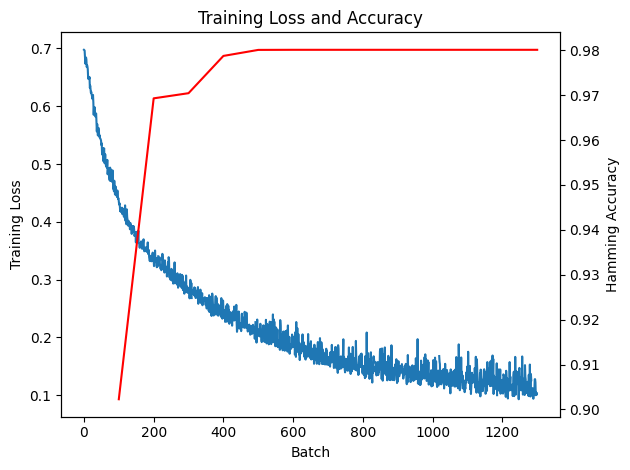

In [22]:
checkpoint = torch.load("training_progress/checkpoint_ep0_b1299.pt")

fig, ax1 = plt.subplots()

ax1.plot(checkpoint['loss_history'], label='Loss')
ax1.set_xlabel('Batch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss and Accuracy')

ax2 = ax1.twinx()
ax2.plot([x[0] for x in checkpoint['acc_history']], [1 - x[1] for x in checkpoint['acc_history']], color='red', label='Accuracy')
ax2.set_ylabel('Hamming Accuracy')

fig.tight_layout()
plt.show()